In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv("AAPL_quarterly_financials.csv")

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
df.index = df.name 
df = pd.DataFrame(df.loc['BasicEPS',:]).iloc[2:,:]
df.index = pd.to_datetime(df.index)
df = df.sort_index().fillna(0.)
df

,BasicEPS
1985-09-30,0.0
1985-12-31,0.004
1986-03-31,0.002
1986-06-30,0.002
1986-09-30,0.0
...,...
2022-09-30,1.29
2022-12-31,1.89
2023-03-31,1.53
2023-06-30,1.27


# 1.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [3]:
from pytrends.request import TrendReq
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["iphone", "M1",'iwatch','ios',
            'Mac','Apple Events','Manchester United','World Cup','UCLA']  # Add your keywords here
start_date = '2004-01-01'
end_date = '2023-09-30'

# Create an empty DataFrame to store the results
d = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    d[keyword] = interest_over_time_df[keyword]
d = d.resample('Q').mean()
d = d.loc[start_date:end_date]
d

,iphone,M1,iwatch,ios,Mac,Apple Events,Manchester United,World Cup,UCLA
date,,,,,,,,,
2004-03-31,0.000000,34.000000,0.333333,1.000000,73.333333,13.000000,13.666667,1.000000,86.666667
2004-06-30,0.000000,32.000000,0.333333,1.666667,71.000000,26.666667,11.333333,1.333333,85.000000
2004-09-30,0.000000,30.000000,0.000000,1.333333,67.666667,21.000000,15.333333,1.333333,75.333333
2004-12-31,0.000000,33.333333,0.333333,1.000000,74.333333,23.666667,15.333333,1.000000,83.000000
2005-03-31,0.000000,32.000000,0.000000,1.000000,80.666667,21.333333,15.333333,1.000000,81.666667
...,...,...,...,...,...,...,...,...,...
2022-09-30,55.666667,81.333333,17.000000,19.666667,41.333333,35.666667,70.666667,2.666667,32.000000
2022-12-31,51.333333,86.000000,16.000000,16.000000,42.000000,29.666667,57.333333,69.666667,39.666667
2023-03-31,49.333333,77.666667,14.666667,14.000000,43.333333,24.333333,77.000000,3.666667,43.000000


# 2.) Normalize all the X data

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(d)

# 3.) Import data. Train, Test, Holdout (80%,15%,5%)

In [6]:
train_data, temp_data = train_test_split(d, test_size=0.2, random_state=42)
test_data, holdout_data = train_test_split(temp_data, test_size=0.25, random_state=42)

In [7]:
# X_train, X_test, y_trains

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [8]:
from sklearn.linear_model import Lasso

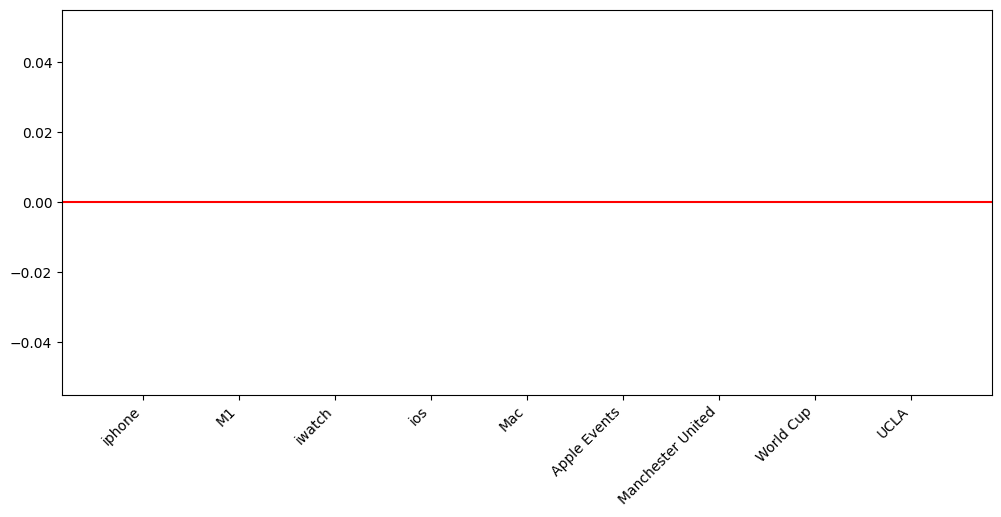

In [9]:
df1 = df.loc[start_date:end_date]
y = df1['BasicEPS']
plt.figure(figsize = (12,5))
lasso = Lasso(alpha = .5)
lasso.fit(X_scaled, y)
coefficient = lasso.coef_
plt.bar(range(len(coefficient)),coefficient)
plt.xticks(range(len(coefficient)), d.columns, rotation=45, ha='right')

plt.axhline(0, color = 'red')
plt.show()

In [10]:
coefficient

array([ 0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.])

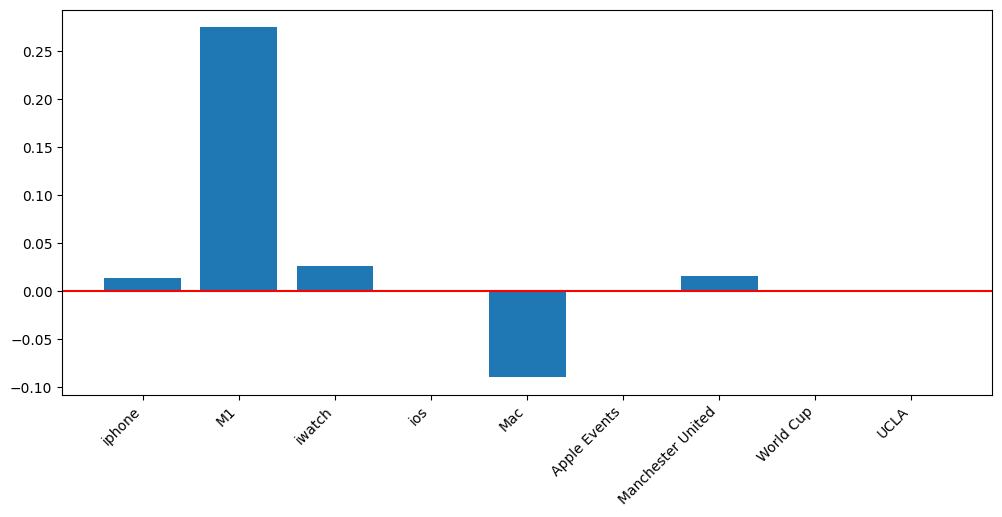

In [11]:
df1 = df.loc[start_date:end_date]
y = df1['BasicEPS']
plt.figure(figsize = (12,5))
lasso = Lasso(alpha = .1)
lasso.fit(X_scaled, y)
coefficient = lasso.coef_
plt.bar(range(len(coefficient)),coefficient)
plt.xticks(range(len(coefficient)), d.columns, rotation=45, ha='right')

plt.axhline(0, color = 'red')
plt.show()

# 5.) Do these coefficient magnitudes make sense?

When alpha = 0.5, all coefficients are shrunk to zero, when alpha is adjusted to 0.1, we can see that iPhone, M1 and iwatch has positive coefficients and Mac has negative coefficients. These coefficients do not make sense because Manchester United also has a postitive coefficient.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

# 7.) Run a cross validation. What is your ideal lambda?